In [1]:
%matplotlib inline
import os
import sys
import platform
import matplotlib
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime,timedelta
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
#rcParams['figure.figsize'] = 10, 10

In [2]:
# custom functions for transducer data import
import Snake_Valley_Data_Import as svdi
import wellapplication as wa
USGS = wa.usgs()
piper = wa.piper()

ok


In [3]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))
print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 7
Python Version 2.7.10 (default, May 23 2015, 09:40:32) [MSC v.1500 32 bit (Intel)]
Pandas Version 0.18.1
Numpy Version 1.11.0
Matplotlib Version 1.5.1
Well Application Version 0.2.13
Scipy Version 0.17.0


In [4]:
if platform.system() == 'Windows':
    drive = 'M:'
else:
    drive = '/media/p/Transcend/'
    
outputFolder = drive + '/GIS/'
raw_archive_folder = drive + '/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/'

# Climate Data

## Import Raw Data

In [5]:
def impClimateData(folder, filename, prefix, yearCutoff):
    df = pd.read_csv(folder + filename, skiprows=15, parse_dates={'dt':[0]}, index_col='dt', na_values='M')
    df[prefix + ' Precipitation'] = pd.to_numeric(df['Precipitation'], errors='coerce')
    df[prefix + ' Snow Depth'] = pd.to_numeric(df['Snow Depth'], errors='coerce')
    df[prefix + ' Snow Fall'] = pd.to_numeric(df['Snow Depth'], errors='coerce')
    df = df[df.index >= pd.datetime(1960,1,1)]
    df[prefix + ' cumdept'] = df[prefix + ' Precipitation'].apply(lambda x: x- df[prefix + ' Precipitation'].mean()).cumsum()
    df[prefix + ' stdcumdept'] = df[prefix + ' Precipitation'].apply(lambda x: (x- df[prefix + ' Precipitation'].mean())/df[prefix + ' Precipitation'].std()).cumsum()
    return df

In [6]:
Eskd = impClimateData(outputFolder, 'UCC_ghcn_USC00422607_2016_03_28_1459219796.csv', 'Eskd', 1960)
Part = impClimateData(outputFolder, 'UCC_ghcn_USC00426708_2016_03_28_1459222060.csv', 'Part', 1960)
Calo = impClimateData(outputFolder, 'UCC_ghcn_USC00421144_2016_03_28_1459222774.csv', 'Calo', 1960)
Fish = impClimateData(outputFolder, 'UCC_ghcn_USC00422852_2016_03_28_1459223049.csv', 'Fish', 1960)
IBAH = impClimateData(outputFolder, 'UCC_ghcn_USC00424174_2016_03_28_1459224176.csv', 'IBAH', 1960)

## Merge Datasets

In [7]:
PC = pd.merge(Part,Calo, left_index=True,right_index=True,how='outer')
EF = pd.merge(Eskd,Fish, left_index=True,right_index=True,how='outer')
IBEF = pd.merge(IBAH,EF, left_index=True,right_index=True,how='outer')
climate = pd.merge(IBEF,PC, left_index=True,right_index=True,how='outer')

In [8]:
climate['avgDept'] = climate[['Eskd cumdept','Fish cumdept','Calo cumdept','Part cumdept']].mean(axis=1)
climate['StdAvgDept'] = climate[['Eskd stdcumdept','Fish stdcumdept','Calo stdcumdept','Part stdcumdept']].mean(axis=1)
climate['movStdAvgDept'] = climate['StdAvgDept'].rolling(window=60, center=True).mean()

# UGS Data

## Import Data

In [9]:
UGS = pd.read_csv(outputFolder + "halfDayUGSdata.csv", low_memory=False, 
                 index_col='DateTime', parse_dates=True)
g = pd.read_csv(outputFolder + 'SitesWQualifier.csv')
#wells = list(g['WellID'].values)
siteDict = pd.Series(g['MonType'].values,index = g['WellID']).to_dict()


#UGS = UGS[UGS['site_no'].isin([11,12,13,14,15,16,17,18,19,20,21,24,25,36,37,38,70,73,74,60,69,58,59])]
UGS = UGS[UGS['site_no'].isin([69,18,31,21,74,70,14,24,37,58,59])]
# assign site types
UGS['MonType'] = UGS['site_no'].apply(lambda x: siteDict[x],1)


wellid = {}
for well in g.WellID:
    wellid[well] = g[g['WellID'] == well]['Well'].values[0]
    
UGS['julian'] = UGS.index.to_julian_date()

TypeDict = {'S':'Wetland Monitoring Sites','P':'Agricultural Monitoring Sites',
            'W':'Sites Outside of Pumping and Evapotranspiration Influence'}

UGS['well_name'] = UGS['site_no'].apply(lambda x: wellid[x],1)

UGS.ix[UGS['site_no']==69,'MonType'] = 'W'
UGS = UGS[(UGS.index > pd.datetime(2010,1,1)) & (UGS.index < pd.datetime(2015,1,1))]

In [10]:
UGSa = UGS[['stdWL','lev_va','avgDiffWL','diff','site_no']].groupby('site_no').resample('1M').mean().drop(['site_no'],axis=1).reset_index().set_index('DateTime')
UGSa['well_name'] = UGSa['site_no'].apply(lambda x: wellid[x],1)

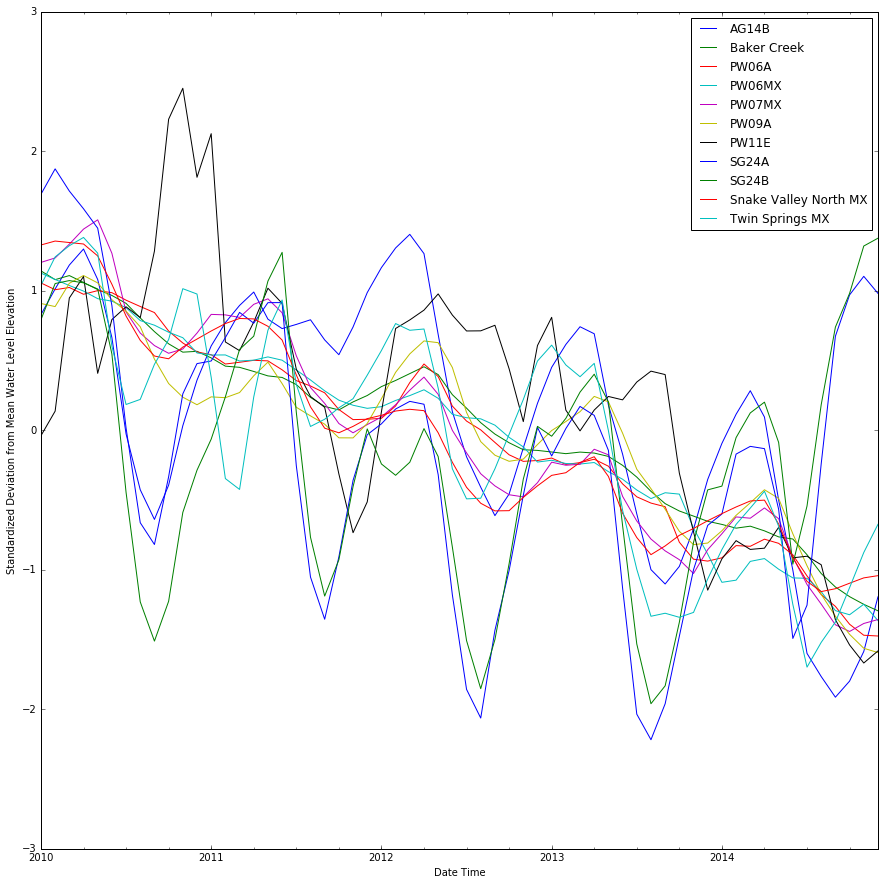

In [11]:
plt.figure()
for g, f in UGSa.groupby('well_name'):
    f['stdWL'].plot(label=g)
    
plt.legend()
plt.ylabel("Standardized Deviation from Mean Water Level Elevation")
plt.xlabel("Date Time")
plt.savefig(outputFolder+"localwells.svg")

## Plot Monthly Data

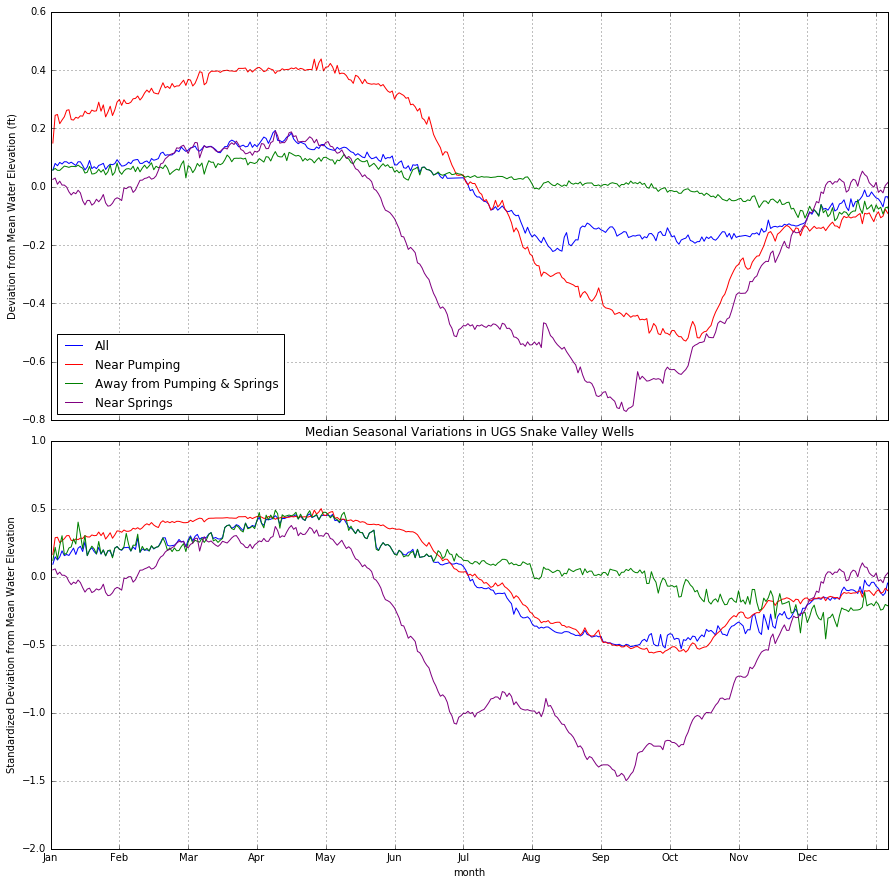

In [12]:
pdf = PdfPages(outputFolder + 'monthly.pdf')

UGS['doy'] = UGS.index.dayofyear



grp = "doy"
data = 'avgDiffWL'
title = 'Deviation from Mean Water Elevation (ft)'
plt.figure()
f, ax = plt.subplots(2, sharex=True)
grpd = UGS.groupby([grp])[data]

x = grpd.median().index
y = grpd.median()
grpd = UGS[UGS['MonType']=='P'].groupby([grp])[data]
x1 = grpd.median().index
y1 = grpd.median()
grpd = UGS[UGS['MonType']=='W'].groupby([grp])[data]
x2 = grpd.median().index
y2 = grpd.median()
grpd = UGS[UGS['MonType']=='S'].groupby([grp])[data]
x3 = grpd.median().index
y3 = grpd.median()

ax[0].plot(x, y, color = 'blue', label = 'All')
ax[0].plot(x1, y1, color = 'red', label = 'Near Pumping')
ax[0].plot(x2, y2, color = 'green', label = 'Away from Pumping & Springs')
ax[0].plot(x3, y3, color = 'purple', label = 'Near Springs')

#ax[0].set_xlim(0,13)
#ax[0].set_xticks(range(0,13))
ax[0].set_ylabel(title)
ax[0].grid()
ax[0].legend(loc=3)

grp = "doy"
data = 'stdWL'
title = 'Standardized Deviation from Mean Water Elevation'

grpd = UGS.groupby([grp])[data]
x = grpd.median().index
y = grpd.median()
grpd = UGS[UGS['MonType']=='P'].groupby([grp])[data]
x1 = grpd.median().index
y1 = grpd.median()
grpd = UGS[UGS['MonType']=='W'].groupby([grp])[data]
x2 = grpd.median().index
y2 = grpd.median()
grpd = UGS[UGS['MonType']=='S'].groupby([grp])[data]
x3 = grpd.median().index
y3 = grpd.median()

ax[1].plot(x, y,color = 'blue', label = 'All')
ax[1].plot(x1, y1, color = 'red', label = 'Near Pumping')
ax[1].plot(x2, y2, color = 'green', label = 'Away from Pumping & Springs')
ax[1].plot(x3, y3, color = 'purple', label = 'Near Springs')

ax[1].set_ylabel(title)
ax[1].grid()
ax[1].set_xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
ax[1].set_ylim(-2,1)
ax[1].set_xticks(range(0,365,30))#dtrng)#,rotation=90)
ax[1].set_xticklabels(datelabels)
ax[0].set_xticks(range(0,365,30))#dtrng)#,rotation=90)
ax[0].set_xticklabels(datelabels)
plt.xlim(0,365)
plt.title('Median Seasonal Variations in UGS Snake Valley Wells')
f.subplots_adjust(hspace=0.05)
pdf.savefig()

plt.figure()

pdf.close()

In [13]:
365/30

12

## Plot Yearly Data

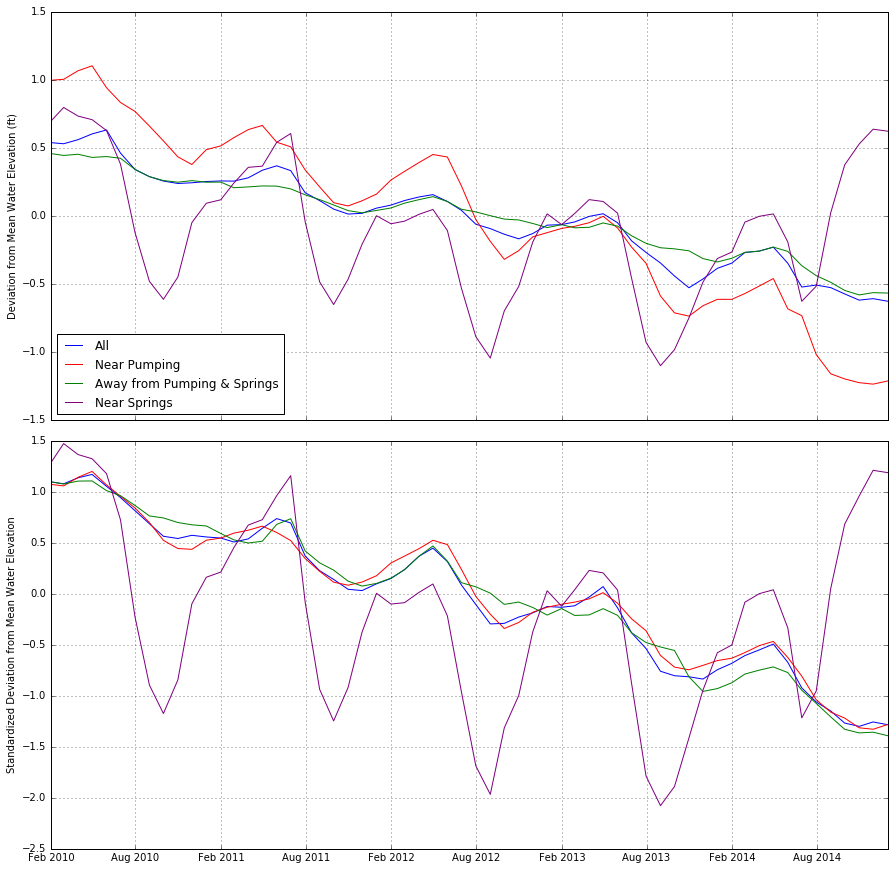

In [14]:
pdf = PdfPages(outputFolder + 'UGS_yearly.pdf')

grp = pd.TimeGrouper("M")
data = 'avgDiffWL'
title = 'Deviation from Mean Water Elevation (ft)'
plt.figure()
f, ax = plt.subplots(2, sharex=True)

grpd = UGS.groupby([grp])[data]
x = grpd.median().index
y = grpd.median()
grpd = UGS[UGS['MonType']=='P'].groupby([grp])[data]
x1 = grpd.median().index
y1 = grpd.median()
grpd = UGS[UGS['MonType']=='W'].groupby([grp])[data]
x2 = grpd.median().index
y2 = grpd.median()
grpd = UGS[UGS['MonType']=='S'].groupby([grp])[data]
x3 = grpd.median().index
y3 = grpd.median()

ax[0].xaxis_date()

ax[0].plot(x, y, color = 'blue', label = 'All')
ax[0].plot(x1, y1, color = 'red', label = 'Near Pumping')
ax[0].plot(x2, y2, color = 'green', label = 'Away from Pumping & Springs')
ax[0].plot(x3, y3, color = 'purple', label = 'Near Springs')

ax[0].set_ylabel(title)
ax[0].grid()
ax[0].legend(loc=3)

data = 'stdWL'
title = 'Standardized Deviation from Mean Water Elevation'

grpd = UGS.groupby([grp])[data]
x = grpd.median().index
y = grpd.median()
grpd = UGS[UGS['MonType']=='P'].groupby([grp])[data]
x1 = grpd.median().index
y1 = grpd.median()
grpd = UGS[UGS['MonType']=='W'].groupby([grp])[data]
x2 = grpd.median().index
y2 = grpd.median()
grpd = UGS[UGS['MonType']=='S'].groupby([grp])[data]
x3 = grpd.median().index
y3 = grpd.median()

ax[1].plot(x, y, color = 'blue', label = 'All')
ax[1].plot(x1, y1, color = 'red', label = 'Near Pumping')
ax[1].plot(x2, y2, color = 'green', label = 'Away from Pumping & Springs')
ax[1].plot(x3, y3, color = 'purple', label = 'Near Springs')
f.subplots_adjust(hspace=0.05)

ax[1].set_ylabel(title)
ax[1].grid()

pdf.savefig()
pdf.close()

## UGS Seasonal Decomposition & Clustering

In [15]:
pivTab = UGS.dropna(subset=['lev_va'])
pivTab['well_name'] = pivTab['site_no'].apply(lambda x: wellid[x],1)
siteList = list(pivTab.site_no.unique())

Conduct seasonal decomposition of each well.  
* Wiki: https://en.wikipedia.org/wiki/Decomposition_of_time_series
* API: http://statsmodels.sourceforge.net/0.6.0/release/version0.6.html

In [16]:
def clusterDecomp(df, grps, well_id, wls, component):
    '''
    INPUT
    -----
    df = time-indexed pandas dataframe
    grps = number of groups to use
    well_id = field in df identifying individual wells
    wls = field in df that you want to analyze
    component = seasonal decomposition field that you want to cluster; options: 'trend', 'residuals','seasonal', or the wls field
    
    RETURNS
    -------
    trends = pandas dataframe with cluster data
    col_linkage = output from cluster analysis
    labs = labels for dendrogram
    '''
    from scipy import cluster
    
    # conduct analysis for each site
    for site in df[well_id].unique():
        # seasonal decomposition function magic is here
        sd = sm.tsa.seasonal_decompose(df.ix[df[well_id]==site, wls].values, freq=365*2+1)
        # populate fields with the seasonal decomposition output
        df.ix[df[well_id]==site,'residuals'] = sd.resid
        df.ix[df[well_id]==site,'seasonal'] = sd.seasonal
        df.ix[df[well_id]==site,'trend'] = sd.trend
    
    # duplicate the date index
    df['date'] = df.index
    
    # pivot the data 
    seasonal_decomp = df.reset_index().pivot(index='date', columns='well_name', values=component).dropna()
    
    # correlate the data
    correlations_array = np.asarray(seasonal_decomp.corr(method = 'pearson'))
    
    # cluster the correlations
    col_linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.pdist(correlations_array.T), method='average')
    
    # group the clusters and match them to well ids
    clusters = scipy.cluster.hierarchy.cut_tree(col_linkage, n_clusters=grps)
    clusterdf = pd.DataFrame({well_id:seasonal_decomp.columns, 'cluster':np.concatenate(clusters.tolist())})
    
    # append cluster group to data
    trends = pd.merge(df, clusterdf, on=well_id)
    trends.reset_index(inplace=True)
    trends.set_index('date',inplace=True)
    
    # make labels for the dendrograms
    labs=[i + ' ' + str(clusterdf[clusterdf[well_id]==i]['cluster'].values) for i in seasonal_decomp.columns]

    return trends, col_linkage, labs

c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


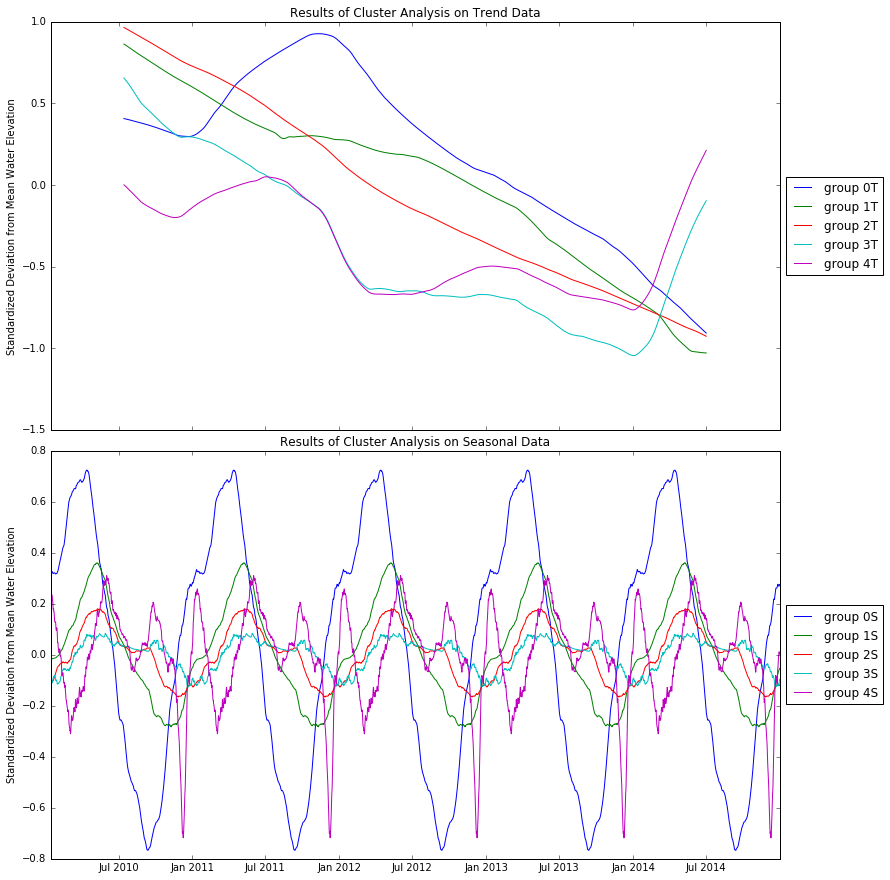

In [17]:
grps = 5

trends, tlink, tlabs= clusterDecomp(pivTab, grps, 'well_name', 'stdWL', 'trend')
season, slink, slabs= clusterDecomp(pivTab, grps, 'well_name', 'stdWL', 'seasonal')
raw, rlink, rlabs= clusterDecomp(pivTab, grps, 'well_name', 'stdWL', 'stdWL')

trendhydro = plt.figure()
f, ax = plt.subplots(2, sharex=True)
for i in range(grps):
    title = 'group ' + str(i)+ 'T'
    A = trends[trends['cluster']==i]
    y = A['trend'].groupby(A.index).median().rolling(window=24).mean()
    x = A['trend'].groupby(A.index).median().rolling(window=24).mean().index
    ax[0].plot(x, y, label = title)
ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[0].set_title('Results of Cluster Analysis on Trend Data')
ax[0].set_ylabel('Standardized Deviation from Mean Water Elevation')
for i in range(grps):
    title = 'group ' + str(i)+'S'
    A = season[season['cluster']==i]
    y = A['seasonal'].groupby(A.index).median().rolling(window=24).mean()
    x = A['seasonal'].groupby(A.index).median().rolling(window=24).mean().index
    ax[1].plot(x, y, label = title)
ax[1].set_ylabel('Standardized Deviation from Mean Water Elevation')
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[1].set_title('Results of Cluster Analysis on Seasonal Data')
f.subplots_adjust(hspace=0.05, right=0.8)
plt.savefig(outputFolder+'clusterTrends.pdf')

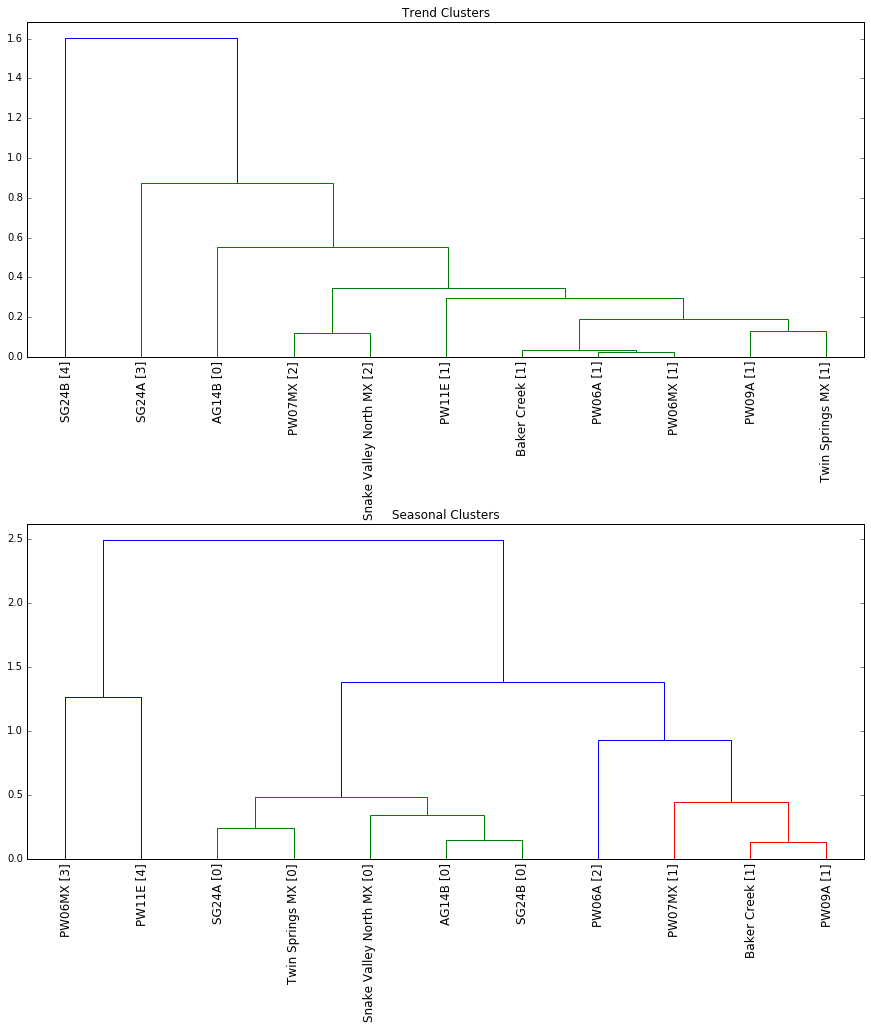

In [18]:
plt.figure()
plt.subplot(211, title='Trend Clusters')
a,b,c,d,e = scipy.cluster.hierarchy.dendrogram(tlink, labels = tlabs, color_threshold=0.90) 
plt.xticks(rotation=90)
plt.subplot(212, title='Seasonal Clusters')
a,b,c,d,e = scipy.cluster.hierarchy.dendrogram(slink, labels = slabs, color_threshold=0.90) 
plt.xticks(rotation=90)
plt.subplots_adjust(hspace=0.5)
plt.savefig(outputFolder+'multDendro.pdf')

In [19]:
trends.groupby('well_name').max().to_csv(outputFolder+'trend_groups1.csv',index_label='Well')
season.groupby('well_name').max().to_csv(outputFolder+'seasonal_groups1.csv',index_label='Well')

In [20]:
pivotWells = pivTab.reset_index().pivot(index='DateTime',columns='well_name',values='stdWL').dropna()

## Determine Slopes

In [21]:
from datetime import timedelta


In [22]:
import statsmodels.api as sm
data = sm.datasets.stackloss.load()

data.exog = sm.add_constant(data.exog)
rlm_model = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print(rlm_results.summary())
print(rlm_results.params)

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 10 Aug 2016                                         
Time:                        08:25:04                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -41.0265      9.792     -4.190      0.0

In [23]:
def RLM(svws, site):
    '''
    RETURNS
    x0, slope, x_prime, y_hat, wellId, wellName, montype
    '''
    
    x0 = svws[site]['julian']
    y = svws[site]['lev_va']
    x1 = svws[site].index.to_julian_date() - svws[site].index.to_julian_date()[0]
    x = sm.add_constant(x1)
    data = svws[site]['lev_va'].to_frame()

    est = sm.RLM(y, x).fit()
    wellId = site
    slope = est.params[1]
    wellName = wellid[site]
    montype = siteDict[site]
    x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    
    const = est.params[0]
    x2 = [svws[site].index[0] + timedelta(i) for i in x1]
    y2 = [i*slope + const for i in x1]
    
    return x0, x2, y2, const, y, slope, x_prime, y_hat, wellId, wellName, montype

def OLS(svws, site):
    '''
    RETURNS
    x0, slope, x_prime, y_hat, wellId, wellName, montype
    '''
    
    x0 = svws[site].index.to_julian_date()
    x1 = svws[site].index.to_julian_date() - svws[site].index.to_julian_date()[0]#.days
    y = svws[site]['lev_va']

    x = sm.add_constant(x1)
    data = svws[site]['lev_va'].to_frame()

    est = sm.OLS(y, x).fit()
    wellId = site
    slope = est.params[1]
    wellName = wellid[site]
    montype = siteDict[site]
    x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)
    rsqrd = (round(float(est.rsquared),2))
    

    
    const = est.params[0]
    x2 = [svws[site].index[0] + timedelta(i) for i in x1]
    y2 = [i*slope + const for i in x1]
    
    return x0, x2, y2, const, y, slope, x_prime, y_hat, wellId, wellName, montype, rsqrd


In [24]:
pdf = PdfPages(outputFolder + 'OLSRLM.pdf')

pivTab = UGS.dropna(subset=['lev_va'])

siteList = list(pivTab.site_no.unique())
svws = {}
svwsEarly = {}
svwsLate = {}
svwsPiv = {}

RLMslope, RLMslope_er, RLMslope_lt, OLSslope, OLSslope_er, OLSslope_lt = [],[],[],[],[],[]

OLSrsqrd, OLSrsqrd_er, OLSrsqrd_lt = [], [], []

wellName, wellId, montype = [], [], []

for site in siteList:
    #fig = plt.figure(figsize=(20,10))
    svws[site] = pivTab[pivTab.site_no == site]
    svwsEarly[site] = svws[site][svws[site].index < pd.datetime(2011,5,1)]
    svwsLate[site] = svws[site][svws[site].index > pd.datetime(2012,5,1)]
    
    n = plt.figure(wellid[site])

    x0, x2, y2, const, y, slope, x_prime, y_hat, wellId1, wellName1, montype1 = RLM(svws, site)
    print(slope, const)
    plt.scatter(x2, y, color='blue', label='intermediate')
    plt.plot(x2, y2, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='RLM fit for all data m= %.5f'%(slope))
    RLMslope.append(slope)

    x0, x2, y2, const, y, slope, x_prime, y_hat, wellId1, wellName1, montype1 = RLM(svwsEarly, site)
    print(slope, const)
    plt.scatter(x2, y, color = 'green', label='early')
    plt.plot(x2, y2, c='lightgreen', alpha=0.9, zorder = 3, linewidth=2.0, label='RLM fit Early m= %.5f'%(slope))
    RLMslope_er.append(slope)
    
    x0, x2, y2, const, y, slope, x_prime, y_hat, wellId1, wellName1, montype1 = RLM(svwsLate, site)
    print(slope, const)
    plt.scatter(x2, y, color='purple', label='late')
    plt.plot(x2, y2, c='pink', alpha=0.9, zorder = 3, linewidth=2.0, label='RLM fit Late m= %.5f'%(slope))
    RLMslope_lt.append(slope)
    

    x0, x2, y2, const, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svws, site)
    #plt.scatter(x0,y)
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit m= ' + str(slope))
    OLSslope.append(slope)
    OLSrsqrd.append(rsqrd)
    
    x0, x2, y2, const, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svwsEarly, site)
    #plt.scatter(x0,y, label='early')
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit Early m= ' + str(slope))
    OLSslope_er.append(slope)
    OLSrsqrd_er.append(rsqrd)
    
    x0, x2, y2, y, const, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svwsLate, site)
    #plt.scatter(x0,y, label='late')
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit Late m= ' + str(slope))
    OLSslope_lt.append(slope)
    OLSrsqrd_lt.append(rsqrd)
    
    wellId.append(wellId1)    
    wellName.append(wellName1)
    montype.append(montype1)

    plt.legend(scatterpoints=1)
    plt.title(str(wellid[site]))
    plt.xlabel('Date')
    ax = plt.gca()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    plt.ylabel('Water Level Elevation (ft)')
    plt.grid()
    plt.tight_layout()
    pdf.savefig(n)
    plt.close()
pdf.close()    

RLMOLS = pd.DataFrame({'RLM slope (ft/day)':RLMslope, 'RLM slope early (ft/day)':RLMslope_er, 'RLM slope late (ft/day)':RLMslope_lt, 
              'OLS slope (ft/day)':OLSslope, 'OLS slope early (ft/day)':OLSslope_er, 'OLS slope late (ft/day)':OLSslope_lt , 
             'OLS r-squared':OLSrsqrd, 'OLS r-squared early':OLSrsqrd_er, 'OLS r-squared late':OLSrsqrd_lt, 
             'Well Name':wellName, 'Well ID':wellId, 'Monitoring Type':montype})
RLMOLS[u'RLM slope (ft/yr)'] = RLMOLS[u'RLM slope (ft/day)'] * 365.25
RLMOLS[u'OLS slope (ft/yr)'] = RLMOLS[u'OLS slope (ft/day)'] * 365.25
RLMOLS[u'RLM early slope (ft/yr)'] = RLMOLS[u'RLM slope early (ft/day)'] * 365.25
RLMOLS[u'OLS early slope (ft/yr)'] = RLMOLS[u'OLS slope early (ft/day)'] * 365.25
RLMOLS[u'RLM late slope (ft/yr)'] = RLMOLS[u'RLM slope late (ft/day)'] * 365.25
RLMOLS[u'OLS late slope (ft/yr)'] = RLMOLS[u'OLS slope late (ft/day)'] * 365.25
RLMOLS.to_csv(outputFolder+'RLMOLS.csv')

RLMOLS.groupby('Monitoring Type')['OLS slope (ft/yr)'].agg({'min':np.min, 'mean':np.mean,'median':np.median,
                                                        'max':np.max, 'std':np.std, 'cnt':(lambda x: np.count_nonzero(~np.isnan(x)))}).reset_index()

(-0.00057305037644982647, 4893.5752501454226)
(-0.00065129519860775142, 4893.5798064911096)
(-0.00074092762833950429, 4893.1793677572205)
(-0.00061793604040634095, 4893.0603480163199)
(-0.0007204169757336204, 4893.0588055128837)
(-0.00079916861992838234, 4892.6318113120824)
(-0.00060290211987434721, 4986.220319168111)
(-0.00063067501076986832, 4986.2330966509326)
(-0.00056855588141414143, 4985.6885455838046)
(-0.0008723820904074607, 4950.6809537144409)
(-0.0017008704862971485, 4950.8112997650569)
(-0.0014322458200471608, 4950.2522636635786)
(-0.00013181060676155723, 5451.4414954039039)
(0.00022461089139257095, 5451.3511627716853)
(-0.00027132565309038667, 5451.4077975781374)
(-0.0011740447855955434, 4984.4657372874035)
(-0.00093577301521083345, 4984.0405789806819)
(-0.0018248910417783572, 4983.7315925784642)
(-0.00050844930564913036, 4817.2022766731543)
(-0.0016899682358715792, 4817.6844191539039)
(0.00082617103636108309, 4816.0769973040024)
(-9.3597445905193363e-05, 4817.508099573919)

,Monitoring Type,std,cnt,min,max,median,mean
0,P,0.097252,4.0,-0.556290,-0.322284,-0.408615,-0.423951
1,S,0.067715,3.0,-0.162951,-0.028261,-0.083363,-0.091525
2,W,0.086463,4.0,-0.229702,-0.048203,-0.215918,-0.177435


# USGS Data

## Download Data

* 160203 -- Great Salt Lake: The Great Salt Lake Basin, excluding the Bear, Weber, and Jordan River Basins. Idaho, Nevada, Utah. Area = 22400 sq.mi.

 * 16020301 -- Hamlin-Snake Valleys. Nevada, Utah. Area =     3100 sq.mi.


In [25]:
HUCName = {16020301:'Hamlin-Snake Valleys'}

allsites = USGS.getStationInfoFromHUC(16020301)
alldata = USGS.getWLfromHUC(16020301)
siteList = list(alldata.site_no.unique())
allsites.to_csv(outputFolder+'usgs_well_locals.csv')

## Add Standardizing Fields

In [26]:
for site in siteList:
    mean = alldata.ix[alldata.site_no==site, 'lev_va'].mean()
    std = alldata.ix[alldata.site_no==site, 'lev_va'].std()
    alldata.ix[alldata.site_no==site, 'diff'] = alldata.ix[alldata.site_no==site, 'lev_va'].diff()
    alldata.ix[alldata.site_no==site, 'avgDiffWL'] = alldata.ix[alldata.site_no==site, 'lev_va'] - mean
    alldata.ix[alldata.site_no==site, 'stdWL'] = alldata.ix[alldata.site_no==site, 'avgDiffWL']/std

In [27]:
alldata.reset_index(inplace=True)
alldata['lev_dt'] = pd.to_datetime(alldata['lev_dt'])
alldata.set_index(['lev_dt'],inplace=True)

In [28]:
alldata.drop(['index'], axis=1, inplace=True)
alldata['year'] = alldata.index.year
alldata['month'] = alldata.index.month
alldata['doy'] = alldata.index.dayofyear
alldata['julian'] = alldata.index.to_julian_date()

## Build Gantt Charts

c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\numpy\lib\function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


45


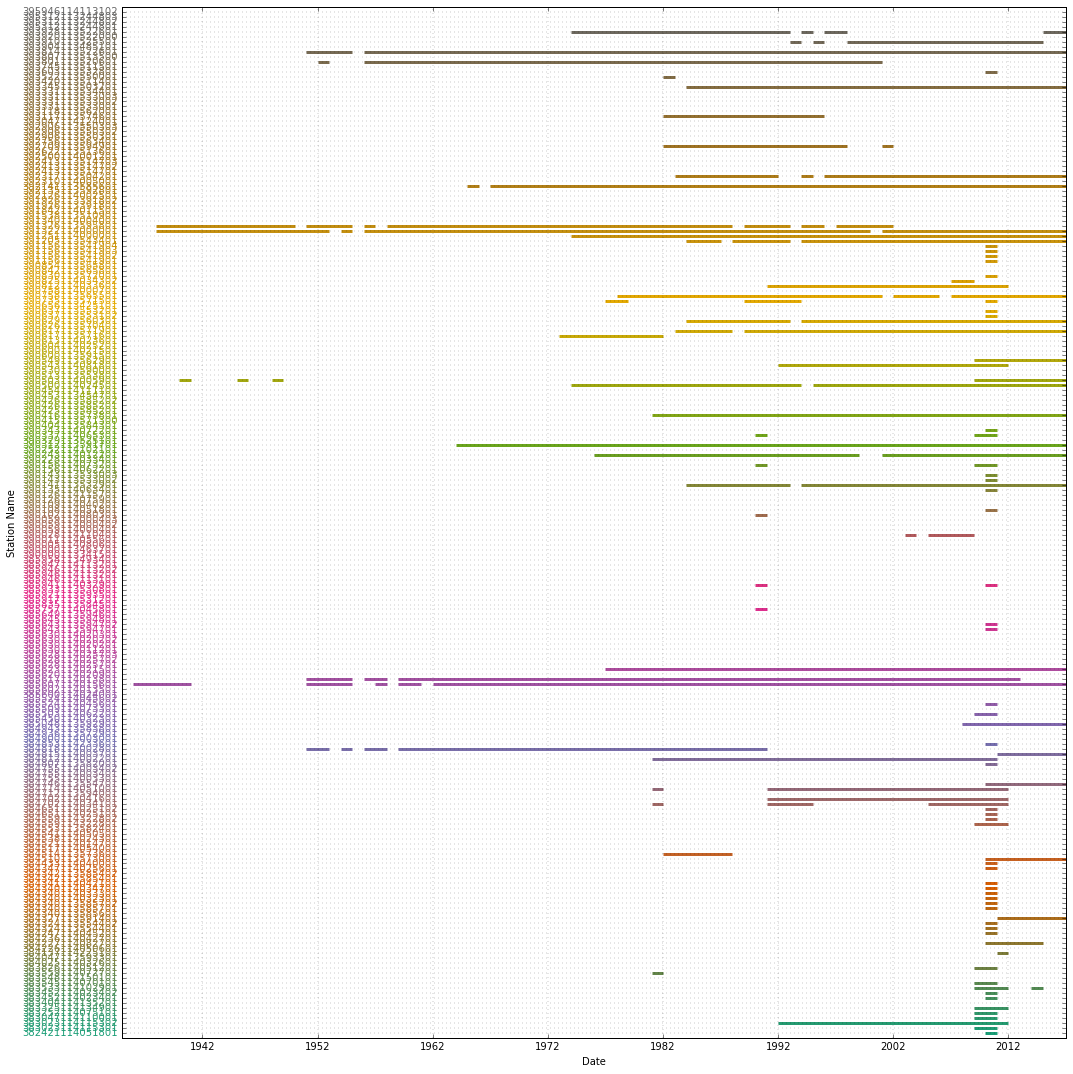

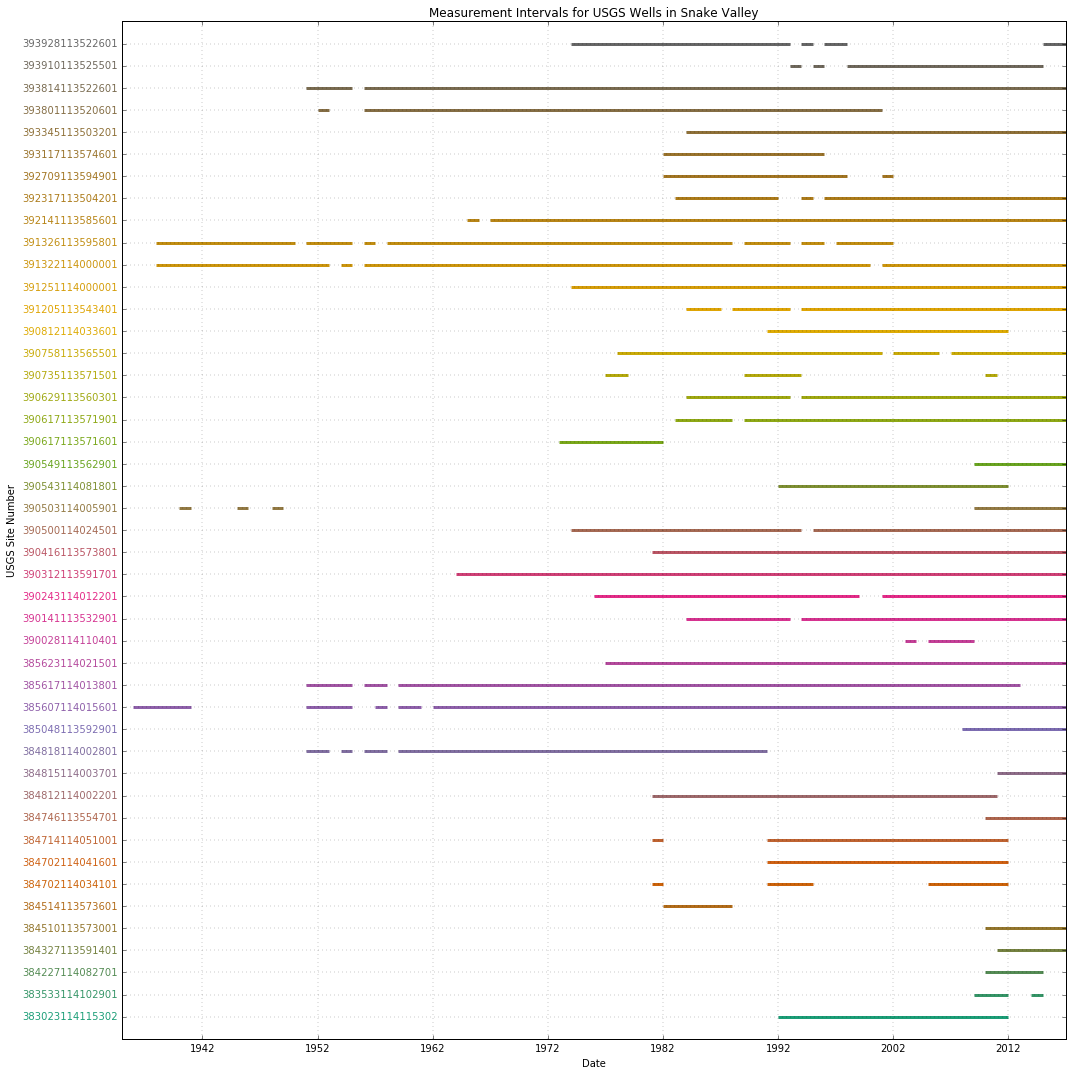

In [29]:
balldata = alldata.reset_index()
balldata.drop_duplicates(subset = ['site_no','lev_dt'], inplace=True)
snakepivdata = balldata.pivot(index= 'lev_dt', columns = 'site_no', values = 'stdWL').sort_index()
pivdata = balldata.pivot(index= 'lev_dt', columns = 'site_no', values = 'lev_va')
pivdata.sort_index(inplace=True)
pivdata = pivdata.resample('A').mean()

info, fig = wa.gantt(pivdata)
infoless = info[info['count']>4]
snakelist = list(infoless.index.values)
df = alldata[alldata['site_no'].isin(snakelist)]
print(len(snakelist))
info, fig = wa.gantt(pivdata, snakelist)
plt.ylabel('USGS Site Number')
plt.title('Measurement Intervals for USGS Wells in Snake Valley')
plt.tight_layout()
plt.savefig(outputFolder+'SnakeGantt.pdf')

In [35]:
#infoless
sitesused = allsites[allsites['site_no'].isin(snakelist)]

In [36]:
sitesused.to_clipboard()

In [55]:
sitesused.index
sitesused.ix[sitesused.index[2],'site_no']

384227114082701

In [48]:
sitesused.columns

Index([u'agency_cd', u'site_no', u'station_nm', u'site_tp_cd', u'dec_lat_va',
       u'dec_long_va', u'coord_acy_cd', u'dec_coord_datum_cd', u'alt_va',
       u'alt_acy_va', u'alt_datum_cd', u'huc_cd'],
      dtype='object')

In [60]:
import simplekml
kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.red  # Make the text red
wellstyle.iconstyle.scale = 0.5  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(sitesused.index):
    pnt = kml.newpoint()
    pnt.name = str(sitesused.ix[i,'site_no'])
    pnt.description = str(sitesused.ix[i,'station_nm'])
    pnt.coords = [(sitesused.ix[i,'dec_long_va'], sitesused.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save("C:\Users\PAULINKENBRANDT\Downloads\usgssites.kml")

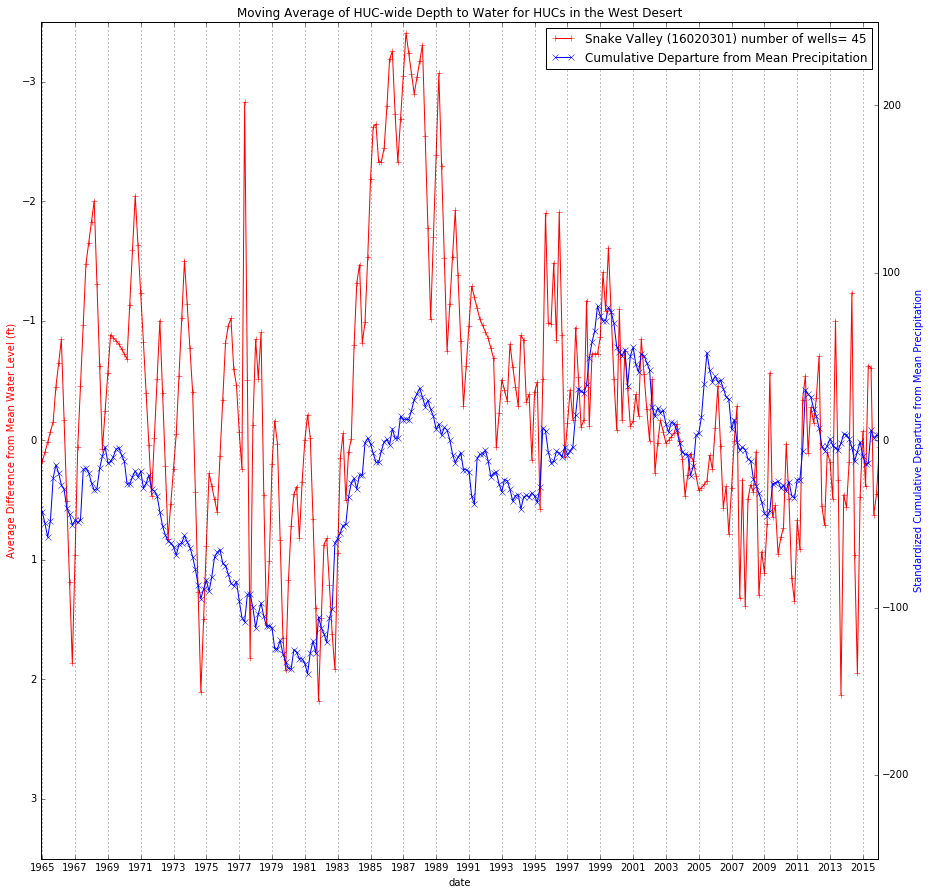

In [31]:
grp = pd.TimeGrouper("M")
data = "avgDiffWL"
title = 'Average Difference from Mean Water Level (ft)'
wid = 4
cen = True

df1 = df.groupby([grp]).median()
df1 = df1[df1.index >= pd.datetime(1962,1,1)]
climate1 = climate[climate.index >= pd.datetime(1962,1,1)]


grpd = df1.resample('2m').median().interpolate(how='time')
clim = climate1.resample('2m').median().interpolate(how='time')

x2 = grpd.index
y2 = grpd[data]
snakegrp = grpd.median().to_frame()
x5 =clim.index
y5 = clim['movStdAvgDept']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x2, y2, '+-', color = 'red', label = 'Snake Valley (16020301) number of wells= ' + str(len(snakelist)))

ax1.set_xlim(pd.datetime(1965,1,1),pd.datetime(2016,1,1))
date_range = pd.date_range('1965-01-01', '2016-01-01', freq='24M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax1.xaxis.set_ticks(date_range)
ax1.set_xlabel('date')
ax1.set_ylim(3.5,-3.5)
ax1.set_ylabel(title, color='red')

ax2.plot(x5,y5, 'x-', color='blue', label='Cumulative Departure from Mean Precipitation')
ax2.set_ylabel('Standardized Cumulative Departure from Mean Precipitation', color='blue')
ax2.set_ylim(-250,250)
ax1.xaxis.grid(True)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title('Moving Average of HUC-wide Depth to Water for HUCs in the West Desert')
plt.savefig(outputFolder+'USGScombDiff.pdf')

In [ ]:
print grpd["avgDiffWL"][1:15]
print clim['StdAvgDept'][2:15]

[  7.96919468e-02   7.78174920e-02   9.10423116e-02   1.04318943e-01
   1.15618870e-01   1.11560607e-01   1.18036090e-01   1.22379130e-01
   1.11539820e-01   8.62037267e-02   7.77892168e-02   7.88662763e-02
   7.71548400e-02   6.58072480e-02   6.30271439e-02   6.69607285e-02
   6.52227445e-02   4.46081825e-02   3.41538454e-02   3.53143258e-02
   3.22483524e-02   2.04991563e-02   1.95051539e-02   2.52125545e-02
   2.28604458e-02   1.05914723e-02  -1.02501606e-03  -4.31549202e-04
   7.17886585e-03  -2.91211282e-03  -5.98119157e-03  -5.23667246e-04
   4.26774119e-04  -1.70760825e-02  -2.44963920e-02  -2.45755406e-02
  -3.81988319e-02  -5.13819807e-02  -6.16322687e-02  -5.79197686e-02
  -5.67362805e-02  -6.59635055e-02  -7.17325899e-02  -7.04665193e-02
  -6.48658146e-02  -6.30545338e-02  -4.99223509e-02  -3.29469722e-02
  -2.79530986e-02  -3.18721054e-02  -2.27145203e-02  -1.79588848e-03
   1.31889441e-02   2.15478258e-02   3.56063366e-02   5.80721170e-02
   7.63477169e-02   8.81698352e-02

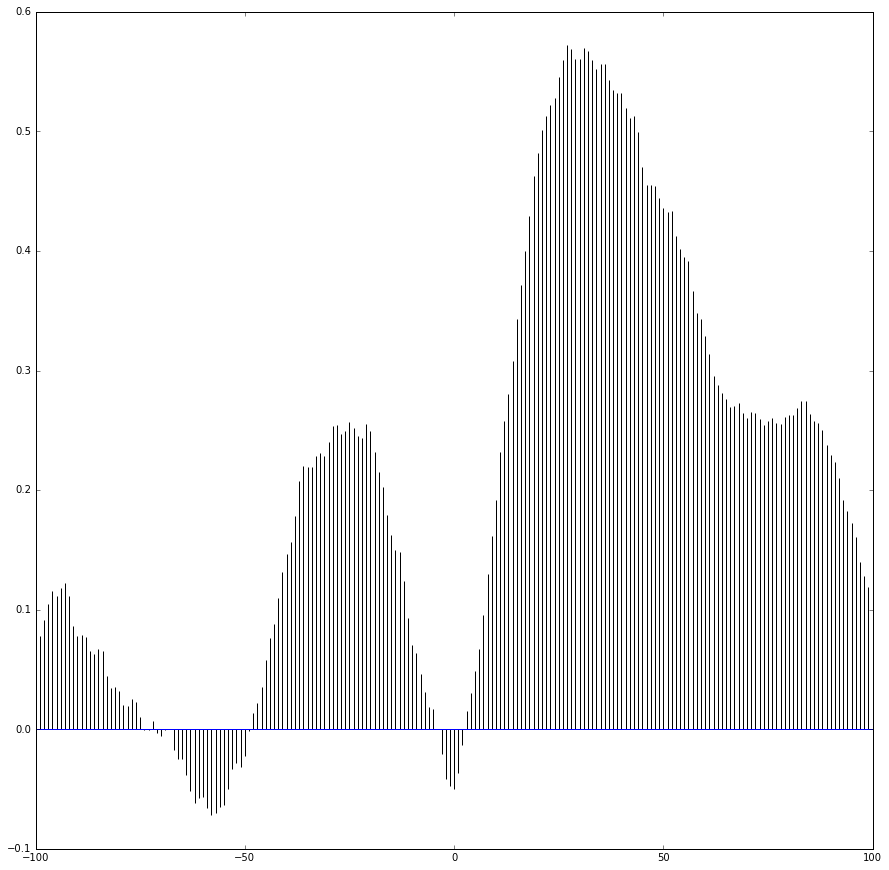

In [221]:
ind = plt.xcorr(grpd["avgDiffWL"][1:],clim['StdAvgDept'][2:],maxlags=100)
print ind[1]
print ind[1].max()
print (ind[1].argmax() - 100)/4

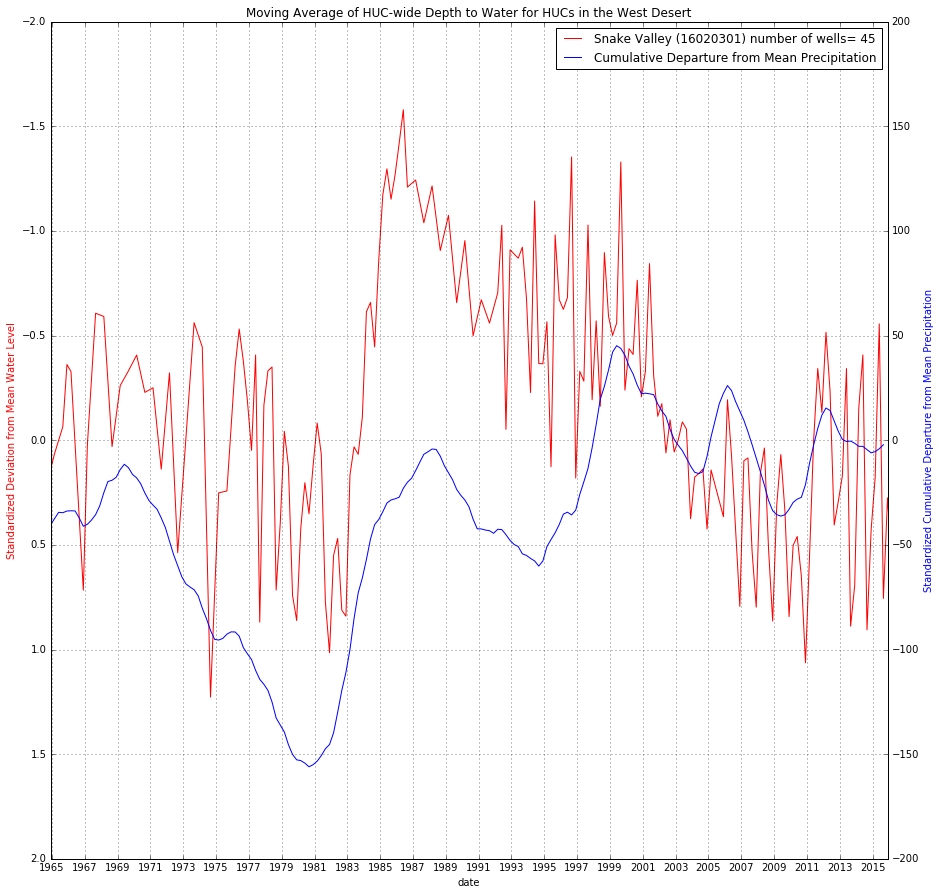

In [246]:
df = alldata[alldata['site_no'].isin(snakelist)]


grp = pd.TimeGrouper("M")
data = "stdWL"
title = 'Standardized Deviation from Mean Water Level'

df1 = df.groupby([grp]).median()
df1 = df1[df1.index >= pd.datetime(1962,1,1)]
climate1 = climate[climate.index >= pd.datetime(1962,1,1)]


grpd = df1.resample('Q').mean().interpolate(how='time')
clim = climate1.resample('Q').mean().interpolate(how='time')



x2 = grpd.index
y2 = grpd[data]
x5 =clim.index
y5 = clim['movStdAvgDept'].rolling(window=6, center=True).mean()

snakegrp = grpd.median().to_frame()
    
fig, ax1 = plt.subplots()

ax1.plot(x2, y2, color = 'red', label = 'Snake Valley (16020301) number of wells= ' + str(len(snakelist)))
ax1.set_xlim(pd.datetime(1965,1,1),pd.datetime(2016,1,1))  
date_range = pd.date_range('1965-01-01', '2016-01-01', freq='24M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax1.xaxis.set_ticks(date_range)
ax1.set_xlim(pd.datetime(1965,1,1),pd.datetime(2016,1,1))  
ax1.set_xlabel('date')
ax1.set_ylim(2,-2)
ax1.set_ylabel(title, color='red')

ax2 = ax1.twinx()
ax2.set_ylim(-200,200)
ax2.plot(x5, y5, color='blue', label='Cumulative Departure from Mean Precipitation')
ax2.set_ylabel('Standardized Cumulative Departure from Mean Precipitation', color='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax1.xaxis.grid(True)
ax2.set_xlim(pd.datetime(1965,1,1),pd.datetime(2016,1,1))  

plt.title('Moving Average of HUC-wide Depth to Water for HUCs in the West Desert')
plt.grid()
plt.savefig(outputFolder+'USGScombStdDiff.pdf')


## USGS Seasonal Decomposition

In [243]:
snakelev = df['stdWL'].resample('M').mean().interpolate(how='time').to_frame()
clim = climate['StdAvgDept'].resample('M').mean().interpolate(how='time').to_frame()
sers = pd.merge(snakelev,clim,left_index=True,right_index=True)

sd = sm.tsa.seasonal_decompose(sers.StdAvgDept)
sdData_cl = pd.DataFrame({'clim_residuals':sd.resid,'clim_seasonal':sd.seasonal,'clim_trend':sd.trend})

sd = sm.tsa.seasonal_decompose(sers.stdWL)
sdData_wl = pd.DataFrame({'wl_residuals':sd.resid,'wl_seasonal':sd.seasonal,'wl_trend':sd.trend})

sdData = pd.merge(sdData_cl,sdData_wl,left_index=True,right_index=True,how='inner')
sdData.dropna(inplace=True)

In [244]:
pdf = PdfPages(outputFolder + 'USGS_OLSRLM.pdf')

pivTab = df.dropna(subset=['lev_va'])

wellid = {}

siteList = list(pivTab.site_no.unique())


for well in siteList:
    wellid[well] = df[df['site_no'] == well]['site_no'].values[0]
    
svws = {}
svwsEarly = {}
svwsLate = {}
svwsPiv = {}

RLMslope, RLMslope_er, RLMslope_lt, OLSslope, OLSslope_er, OLSslope_lt = [],[],[],[],[],[]

OLSrsqrd, OLSrsqrd_er, OLSrsqrd_lt = [], [], []

wellName, wellId, montype = [], [], []

for site in siteList:
    #fig = plt.figure(figsize=(20,10))
    svws[site] = pivTab[pivTab.site_no == site]
    svwsEarly[site] = svws[site][svws[site].index < pd.datetime(1981,1,1)]
    svwsLate[site] = svws[site][svws[site].index > pd.datetime(1990,5,1)]
    
    n = plt.figure(wellid[site])
    

    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svws, site)
    #plt.scatter(x0,y)
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit m= ' + str(slope))
    OLSslope.append(slope)
    OLSrsqrd.append(rsqrd)
    
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svwsEarly, site)
    #plt.scatter(x0,y, label='early')
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit Early m= ' + str(slope))
    OLSslope_er.append(slope)
    OLSrsqrd_er.append(rsqrd)
    
    x0, y, slope, x_prime, y_hat, wellId1, wellName1, montype1, rsqrd = OLS(svwsLate, site)
    #plt.scatter(x0,y, label='late')
    #plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit Late m= ' + str(slope))
    OLSslope_lt.append(slope)
    OLSrsqrd_lt.append(rsqrd)
    
    wellId.append(wellId1)    
    wellName.append(wellName1)


    plt.legend()
    plt.title(str(wellid[site]))
    plt.xlabel('Julian Day')
    plt.ylabel('Discharge (gpm)')
    plt.grid()
    plt.tight_layout()
    pdf.savefig(n)
    plt.close()
pdf.close()   

KeyError: 383023114115302

In [32]:
pdf = PdfPages(outputFolder + 'USGS_RLM.pdf')

pivTab = df.dropna(subset=['lev_va'])

siteList = list(pivTab.site_no.unique())
svws = {}
svwsPiv = {}

wellid = {}

for well in g.WellID:
    wellid[well] = g[g['WellID'] == well]['Well'].values[0]

slope = []
wellName = []
rsqrd = []
wellId = []
montype = []

for site in siteList:
    #fig = plt.figure(figsize=(20,10))
    svws[site] = pivTab[pivTab.site_no == site]
    n = plt.figure(site)

    x0 = svws[site]['julian']
    y = svws[site]['lev_va']

    x = sm.add_constant(x0)
    data = svws[site]['lev_va'].to_frame()

    est = sm.RLM(y, x).fit()

    wellId.append(site)
    slope.append(est.params[1])
    
    x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)
    
    plt.scatter(x0,y)
    plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')
    plt.title(str(site) + " m= " + str(est.params[1]))
    plt.xlabel('Julian Day')
    plt.ylabel('Discharge (gpm)')
    plt.grid()
    pdf.savefig(n)
    plt.close()
pdf.close()   

AttributeError: 'str' object has no attribute 'WellID'

In [29]:
RLMRes = pd.DataFrame({u'Well ID':wellId, u'Monitoring Type': montype, u'well':wellName,u'RLM slope (ft/day)':slope})
RLMRes[u'RLM slope (ft/yr)'] = RLMRes[u'RLM slope (ft/day)'] * 365.25
#OLSRes.to_csv(outputFolder + "RLMfits.csv")
OLSRes = pd.DataFrame({u'Well ID':wellId, u'Monitoring Type': montype, u'well':wellName,u'OLS slope (ft/day)':slope,u'r-squared':rsqrd})
OLSRes[u'OLS slope (ft/yr)'] = OLSRes[u'OLS slope (ft/day)'] * 365.25
#OLSRes.to_csv(outputFolder + "OLSfits.csv")
pd.merge(OLSRes, RLMRes, on='Well ID', how='outer')

,Monitoring Type_x,OLS slope (ft/day),r-squared,well_x,OLS slope (ft/yr),Monitoring Type_y,RLM slope (ft/day),Well ID,well_y,RLM slope (ft/yr)


In [30]:
pdf = PdfPages(outputFolder + 'USGS_monthly.pdf')
grp = "month"


data = "diff"
title = 'Change in Water Level (ft)'
monthlyPlot(alldata, grp, data, title)
plt.title('All Wells')

grp = pd.TimeGrouper("M")
data = 'diff'
title = 'Deviation from Mean Water Level (ft)'
monthlyPlot(alldata, grp, data, title)
plt.title('All Wells')

pdf = PdfPages(outputFolder + 'monthly.pdf')
grp = "month"

data = "diff"
title = 'Change in Water Level (ft)'
monthlyPlot(alldata, grp, data, title)
plt.title('All Wells')

grp = pd.TimeGrouper("M")
data = 'diff'
title = 'Deviation from Mean Water Level (ft)'
monthlyPlot(alldata, grp, data, title)
plt.title('All Wells')


pdf.close()

NameError: name 'monthlyPlot' is not defined